## Pre-requirements

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%bash
rm sample_data -R # remove pre-existing data from the storage

# As read and write operations from google drive are slow, we suggest to copy and unzip
# the dataset in a local directory on the Colab's machine.
mkdir -p ek_data/frames

for SLICE in "D1" # "D2" D3
do
  # Copy the *.tar.gz files of Epic-Kitchen
  cp /content/drive/MyDrive/MLDL23/EPIC-Kitchens-55/$SLICE/*.tar.gz ./ek_data

  # Untar
  for file in ./ek_data/*.tar.gz; do
    fn=$(basename $file)
    fn=${fn/.tar.gz/}
    # ls -lah $file
    mkdir -p ek_data/frames/$fn
    tar xf $file --directory=ek_data/frames/$fn
  done

  # Remove the archives already extracted
  rm ./ek_data/*.tar.gz
done

In [ ]:
!git clone -b main https://www.github.com/antoniodalmaso/mldl23-ego.git mldl23-ego

fatal: destination path 'mldl23-ego' already exists and is not an empty directory.


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import pandas as pd
import numpy as np

import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)

random_state = 42
np.random.seed(random_state)

## Retrieving the dataset

In [ ]:
from os import X_OK
# dataset labels' names
labels_dictionary = {
    2: 'open',
    0: 'get',
    3: 'close',
    1: 'place',
    4: 'clean',
    7: 'pour',
    5: 'cut',
    6: 'mix'
}

split = "D1_train" # used kitchen

data = unpickle(f"mldl23-ego/train_val/{split}.pkl") # all actions info
central_images = []

# central image path for each action
for i in range(len(data)):
  video_id = data["video_id"][i]
  length_video = data["stop_frame"][i] - data["start_frame"][i]
  central_frame = str(data["start_frame"][i] + round(length_video/2))
  path = "img_0000000000"[:-len(central_frame)] + central_frame
  central_image = f"ek_data/frames/{video_id}/{path}.jpg"
  central_images.append(central_image)

# retrieve corresponding features
df = unpickle(f"/content/mldl23-ego/saved_features/last_{split}.pkl")
features = df["features"]

# concatenate the 5 features of each action together
X = np.vstack([np.concatenate([feat["features_RGB"][i] for i in range(5)]) for feat in features])
y = np.array(df["labels"])

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"central_images length: {len(central_images)}")

X shape: (1543, 5120)
y shape: (1543,)
central_images length: 1543


## Data Exploration

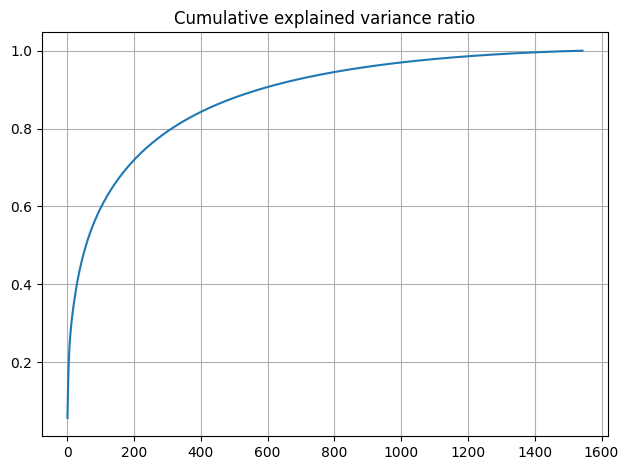

Number of mainteined components: 574


In [ ]:
# EXPLAINED VARIANCE RATIO PLOT #
pca = PCA()
pca.fit(X)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots()
ax.plot(np.arange(1, explained_variance.size+1), explained_variance)
ax.set_title("Cumulative explained variance ratio")
ax.grid(True)
fig.tight_layout()
plt.show()

# ACTUAL DIMENSIONALITY REDUCTION #
pca = PCA(n_components = 0.9)
X_pca = pca.fit_transform(X)

print(f'Number of mainteined components: {X_pca.shape[1]}')

In [ ]:
# CLUSTERING #
k = 8 # looking for 8 clusters
kmeans = KMeans(n_clusters = k, random_state = random_state, n_init=10)
kmeans.fit(X_pca)

print(f"Silhouette score: {silhouette_score(X_pca, kmeans.labels_)}")

Silhouette score: 0.03388006612658501


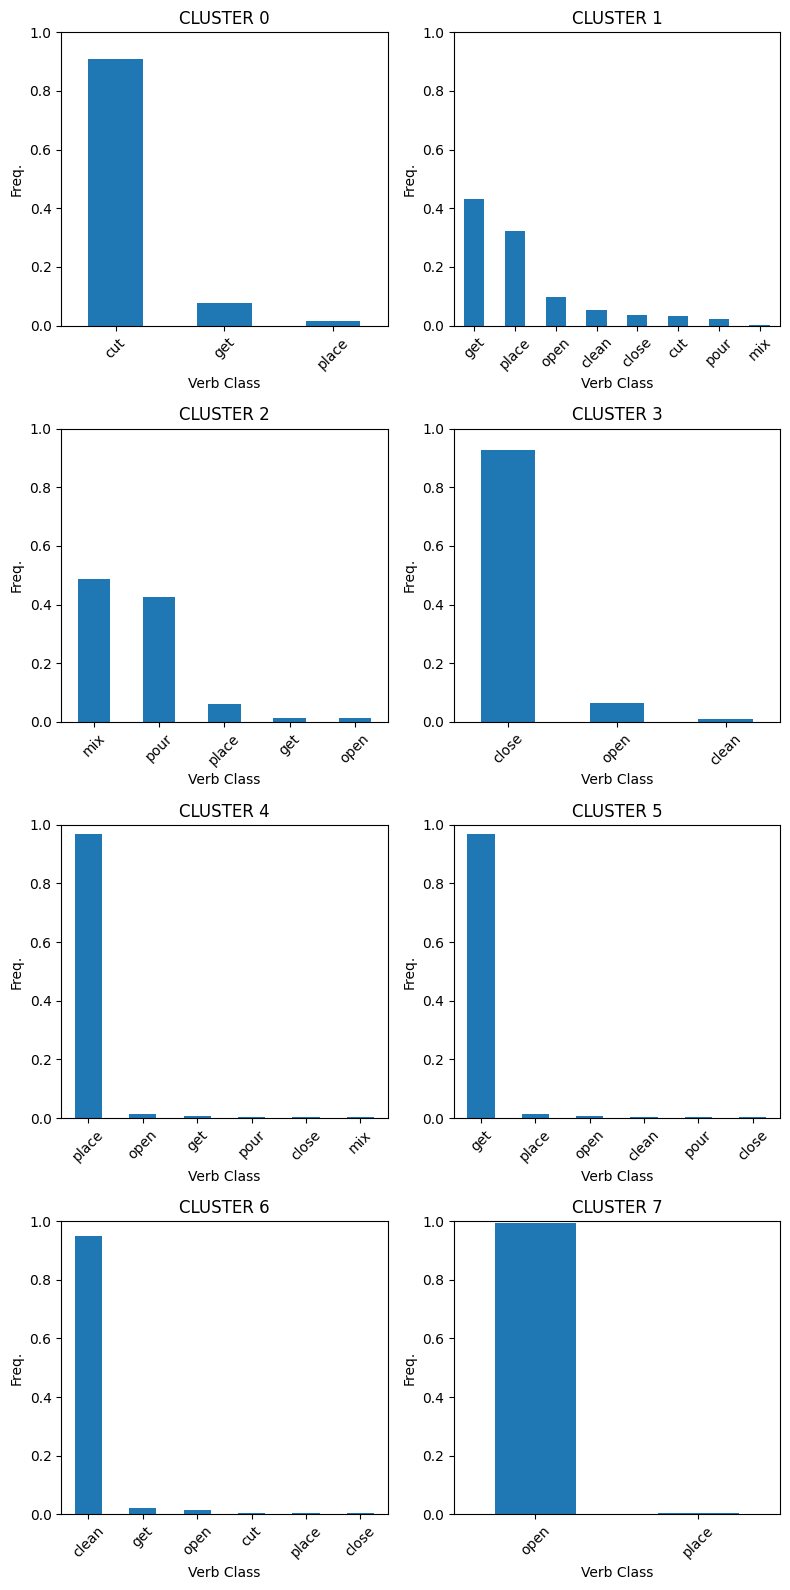

In [ ]:
# CLUSTERS COMPOSITION W.R.T. THE ORIGINAL LABELS #
fig, ax = plt.subplots(4, 2,  figsize=(8, 16))

for i in range(k):
    ir = i // 2
    ic = i % 2

    labels = y[kmeans.labels_ == i]

    distribution = pd.Series(labels).value_counts(normalize=True)
    distribution.rename(lambda x: labels_dictionary[x]).plot(kind="bar", ax = ax[ir, ic], rot=45)

    ax[ir, ic].set_title(f"CLUSTER {i}")
    ax[ir, ic].set_ylim(0, 1)
    ax[ir, ic].set_xlabel("Verb Class")
    ax[ir, ic].set_ylabel("Freq.")

fig.tight_layout()
plt.savefig("cluster_plot_2.svg", format="svg")

## Score Graphs

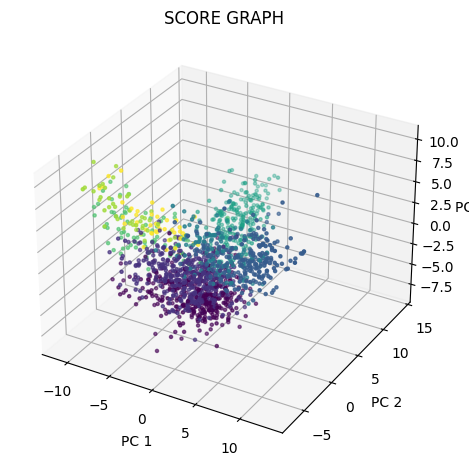

In [ ]:
pca_plot = PCA(n_components = 3)
X_plot = pca_plot.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_plot[:, 0], X_plot[:, 1], X_plot[:, 2], s=5, c=y)

ax.set_title("SCORE GRAPH")

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

fig.tight_layout()

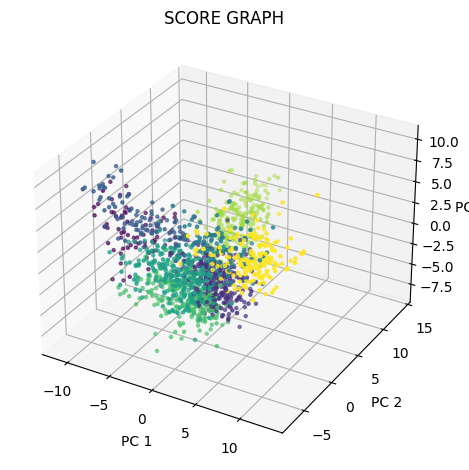

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_plot[:, 0], X_plot[:, 1], X_plot[:, 2], s=5, c=kmeans.labels_)

ax.set_title("SCORE GRAPH")

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

fig.tight_layout()

## Plot with images

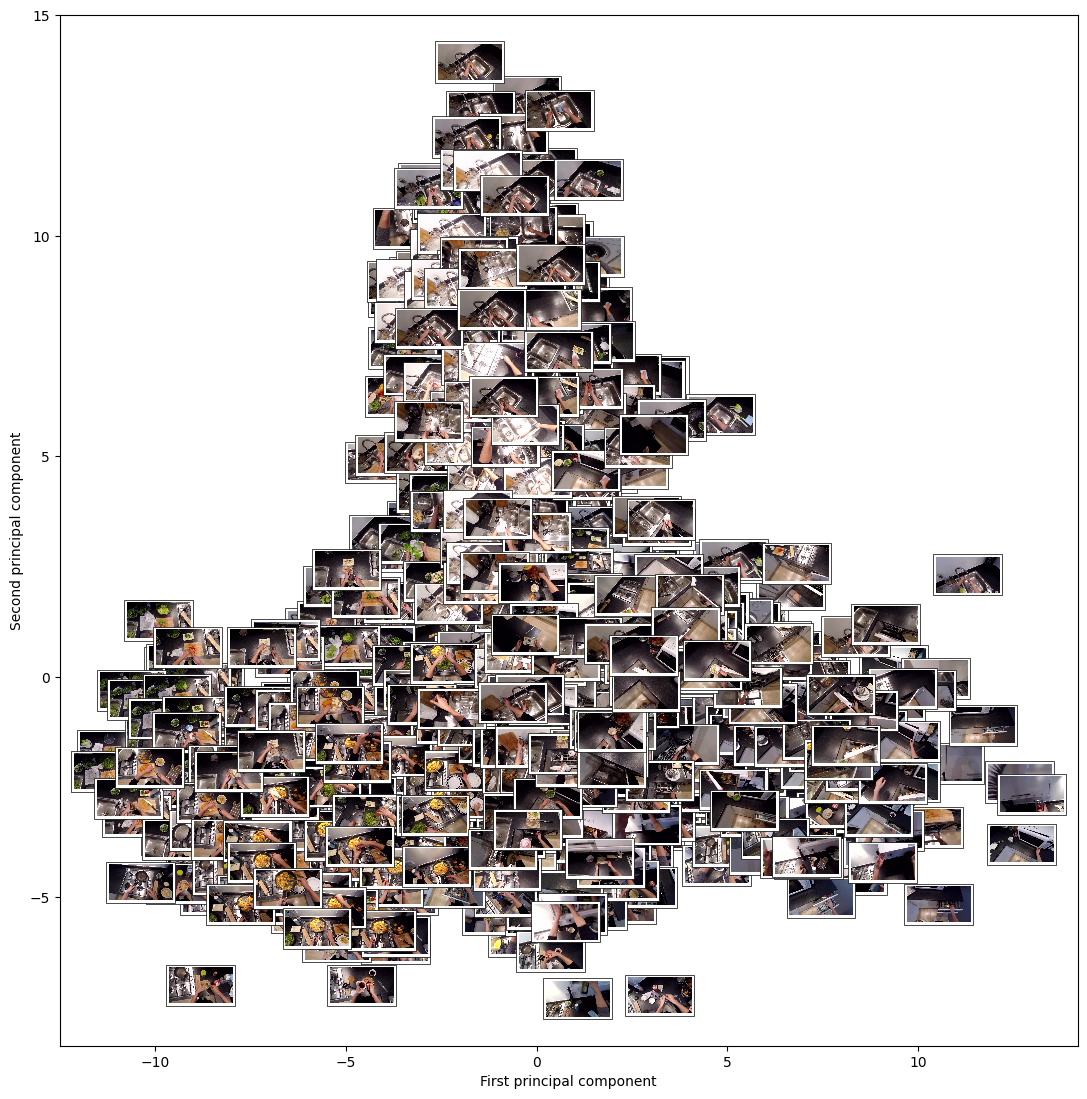

In [ ]:
# PLOT ON THE FIRST 2 PRINCIPAL COMPONENTS
X_reduced = X_pca[:,:2]

fig, ax = plt.subplots(figsize=(12,12))
sc = ax.scatter(X_reduced[:,0], X_reduced[:,1], s=2, c=y)

ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')

for x0, y0, path in zip(X_reduced[:,0], X_reduced[:,1], central_images):
  ab = AnnotationBbox(getImage(path, zoom=0.1), (x0, y0), frameon=True, pad=0.2, bboxprops={'linewidth': 0.5})
  ax.add_artist(ab)

fig.tight_layout()

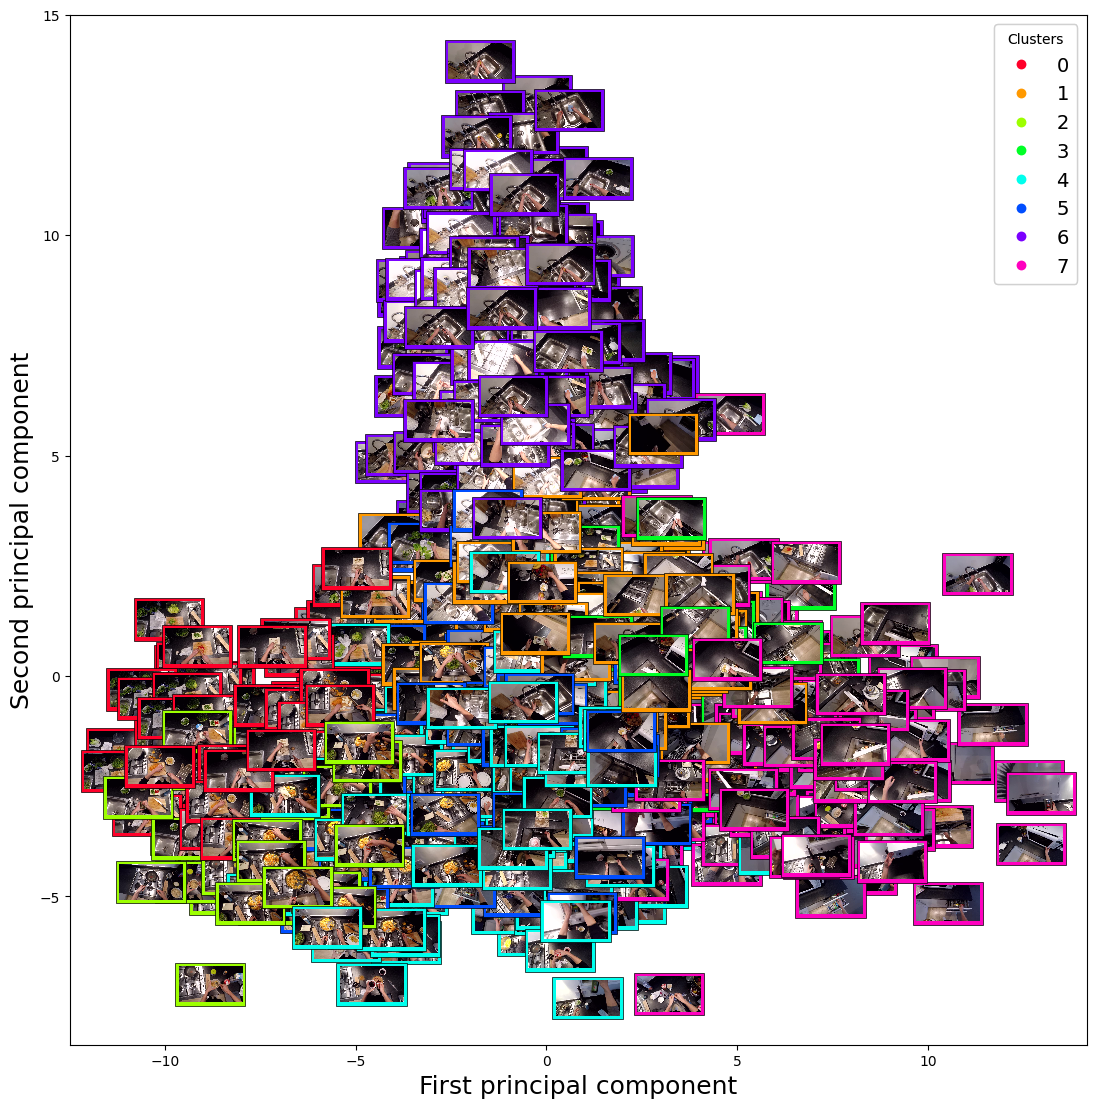

In [ ]:
# CLUSTERING PLOT
cmap = mpl.colormaps['gist_rainbow']
color = cmap(np.linspace(0, 1, 8))

# Predict the cluster labels for each point
Z = kmeans.predict(X_pca)

fig, ax = plt.subplots(figsize=(12,12))
sc = ax.scatter(X_reduced[:,0], X_reduced[:,1], s=2, c=Z, cmap=cmap)

ax.set_xlabel('First principal component', fontsize=18)
ax.set_ylabel('Second principal component', fontsize=18)

for x0, y0, pred, path in zip(X_reduced[:,0], X_reduced[:,1], Z, central_images):
  ab = AnnotationBbox(getImage(path, zoom=0.1), (x0, y0), frameon=True, pad=0.25, bboxprops={'linewidth': 0.5, 'facecolor':color[pred], 'alpha':1})
  ax.add_artist(ab)

legend1 = ax.legend(*sc.legend_elements(), title='Clusters', fontsize=14)
ax.add_artist(legend1)
fig.tight_layout()
plt.savefig('cluster_plot.svg', format='svg')